In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [2]:
metadata = pd.read_csv("movies_metadata.csv")

c:\users\dell\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
metadata.shape

(45466, 24)

In [4]:
metadata.head(3)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [5]:
C = metadata['vote_average'].mean()
print(C)

5.618207215134185


In [6]:
m = metadata['vote_count'].quantile(0.90)
print(m)

160.0


In [7]:
q_movies = metadata.copy().loc[metadata['vote_count'] >= m]
q_movies.shape

(4555, 24)

In [8]:
q_movies = q_movies[:5000]
q_movies.shape

(4555, 24)

In [9]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    print(v,R,m,C)
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

    

5415.0 7.7 160.0 5.618207215134185
2413.0 6.9 160.0 5.618207215134185
173.0 5.7 160.0 5.618207215134185
1886.0 7.7 160.0 5.618207215134185
174.0 5.5 160.0 5.618207215134185
1194.0 6.6 160.0 5.618207215134185
199.0 6.5 160.0 5.618207215134185
210.0 5.7 160.0 5.618207215134185
423.0 7.1 160.0 5.618207215134185
1343.0 7.8 160.0 5.618207215134185
364.0 7.2 160.0 5.618207215134185
539.0 6.5 160.0 5.618207215134185
1128.0 6.1 160.0 5.618207215134185
224.0 5.4 160.0 5.618207215134185
305.0 6.4 160.0 5.618207215134185
199.0 6.5 160.0 5.618207215134185
394.0 6.0 160.0 5.618207215134185
365.0 7.1 160.0 5.618207215134185
308.0 7.6 160.0 5.618207215134185
249.0 6.4 160.0 5.618207215134185
2470.0 7.4 160.0 5.618207215134185
756.0 6.0 160.0 5.618207215134185
350.0 7.3 160.0 5.618207215134185
828.0 6.9 160.0 5.618207215134185
452.0 5.4 160.0 5.618207215134185
177.0 6.7 160.0 5.618207215134185
5915.0 8.1 160.0 5.618207215134185
1509.0 6.7 160.0 5.618207215134185
3334.0 8.1 160.0 5.618207215134185
181.

3962.0 7.3 160.0 5.618207215134185
2528.0 6.2 160.0 5.618207215134185
1289.0 6.5 160.0 5.618207215134185
439.0 4.1 160.0 5.618207215134185
1447.0 4.2 160.0 5.618207215134185
1741.0 7.3 160.0 5.618207215134185
606.0 6.4 160.0 5.618207215134185
1612.0 6.8 160.0 5.618207215134185
4521.0 6.9 160.0 5.618207215134185
1338.0 7.2 160.0 5.618207215134185
404.0 6.0 160.0 5.618207215134185
663.0 6.6 160.0 5.618207215134185
508.0 5.4 160.0 5.618207215134185
384.0 6.6 160.0 5.618207215134185
752.0 6.4 160.0 5.618207215134185
344.0 5.0 160.0 5.618207215134185
440.0 6.5 160.0 5.618207215134185
255.0 5.7 160.0 5.618207215134185
859.0 6.2 160.0 5.618207215134185
971.0 7.2 160.0 5.618207215134185
218.0 7.1 160.0 5.618207215134185
181.0 6.3 160.0 5.618207215134185
359.0 6.8 160.0 5.618207215134185
263.0 5.8 160.0 5.618207215134185
1340.0 7.7 160.0 5.618207215134185
644.0 7.0 160.0 5.618207215134185
353.0 6.2 160.0 5.618207215134185
1556.0 7.5 160.0 5.618207215134185
185.0 6.5 160.0 5.618207215134185
181.

998.0 5.8 160.0 5.618207215134185
300.0 7.0 160.0 5.618207215134185
844.0 7.5 160.0 5.618207215134185
411.0 7.0 160.0 5.618207215134185
430.0 6.8 160.0 5.618207215134185
444.0 6.9 160.0 5.618207215134185
722.0 6.9 160.0 5.618207215134185
790.0 7.1 160.0 5.618207215134185
401.0 7.2 160.0 5.618207215134185
747.0 7.6 160.0 5.618207215134185
445.0 7.8 160.0 5.618207215134185
178.0 6.6 160.0 5.618207215134185
161.0 5.7 160.0 5.618207215134185
330.0 7.0 160.0 5.618207215134185
218.0 7.4 160.0 5.618207215134185
197.0 5.6 160.0 5.618207215134185
377.0 7.3 160.0 5.618207215134185
713.0 6.5 160.0 5.618207215134185
384.0 5.9 160.0 5.618207215134185
196.0 6.5 160.0 5.618207215134185
383.0 6.7 160.0 5.618207215134185
763.0 7.3 160.0 5.618207215134185
738.0 6.5 160.0 5.618207215134185
281.0 5.8 160.0 5.618207215134185
362.0 6.8 160.0 5.618207215134185
440.0 6.4 160.0 5.618207215134185
681.0 6.2 160.0 5.618207215134185
655.0 6.3 160.0 5.618207215134185
294.0 6.3 160.0 5.618207215134185
429.0 7.3 160.

445.0 5.7 160.0 5.618207215134185
764.0 5.7 160.0 5.618207215134185
7188.0 7.5 160.0 5.618207215134185
291.0 5.1 160.0 5.618207215134185
592.0 6.8 160.0 5.618207215134185
277.0 7.2 160.0 5.618207215134185
322.0 7.7 160.0 5.618207215134185
237.0 6.1 160.0 5.618207215134185
232.0 6.7 160.0 5.618207215134185
210.0 6.5 160.0 5.618207215134185
464.0 6.0 160.0 5.618207215134185
3857.0 7.2 160.0 5.618207215134185
3403.0 7.8 160.0 5.618207215134185
444.0 5.5 160.0 5.618207215134185
1100.0 6.5 160.0 5.618207215134185
1317.0 7.4 160.0 5.618207215134185
311.0 5.9 160.0 5.618207215134185
230.0 6.4 160.0 5.618207215134185
235.0 5.6 160.0 5.618207215134185
430.0 6.0 160.0 5.618207215134185
8892.0 8.0 160.0 5.618207215134185
193.0 6.6 160.0 5.618207215134185
3087.0 7.7 160.0 5.618207215134185
160.0 7.3 160.0 5.618207215134185
278.0 8.1 160.0 5.618207215134185
457.0 6.7 160.0 5.618207215134185
1832.0 7.2 160.0 5.618207215134185
256.0 6.8 160.0 5.618207215134185
542.0 7.2 160.0 5.618207215134185
254.0 

198.0 6.7 160.0 5.618207215134185
170.0 7.5 160.0 5.618207215134185
170.0 7.2 160.0 5.618207215134185
581.0 7.3 160.0 5.618207215134185
3082.0 6.7 160.0 5.618207215134185
2462.0 6.2 160.0 5.618207215134185
195.0 5.9 160.0 5.618207215134185
6037.0 7.7 160.0 5.618207215134185
339.0 6.3 160.0 5.618207215134185
236.0 7.3 160.0 5.618207215134185
1593.0 6.3 160.0 5.618207215134185
851.0 5.2 160.0 5.618207215134185
339.0 5.4 160.0 5.618207215134185
567.0 6.7 160.0 5.618207215134185
178.0 4.1 160.0 5.618207215134185
520.0 6.6 160.0 5.618207215134185
165.0 7.9 160.0 5.618207215134185
192.0 6.9 160.0 5.618207215134185
228.0 7.7 160.0 5.618207215134185
687.0 5.7 160.0 5.618207215134185
1009.0 6.2 160.0 5.618207215134185
1974.0 7.1 160.0 5.618207215134185
704.0 6.3 160.0 5.618207215134185
3163.0 7.7 160.0 5.618207215134185
185.0 6.9 160.0 5.618207215134185
178.0 6.8 160.0 5.618207215134185
653.0 6.5 160.0 5.618207215134185
367.0 5.5 160.0 5.618207215134185
178.0 7.7 160.0 5.618207215134185
240.0 6

453.0 4.8 160.0 5.618207215134185
662.0 6.5 160.0 5.618207215134185
257.0 6.7 160.0 5.618207215134185
1048.0 6.1 160.0 5.618207215134185
396.0 7.3 160.0 5.618207215134185
1749.0 6.1 160.0 5.618207215134185
477.0 5.1 160.0 5.618207215134185
1429.0 5.4 160.0 5.618207215134185
1728.0 7.5 160.0 5.618207215134185
1083.0 6.9 160.0 5.618207215134185
269.0 5.3 160.0 5.618207215134185
912.0 6.3 160.0 5.618207215134185
504.0 5.1 160.0 5.618207215134185
435.0 6.4 160.0 5.618207215134185
497.0 6.2 160.0 5.618207215134185
2949.0 6.4 160.0 5.618207215134185
461.0 5.9 160.0 5.618207215134185
743.0 7.1 160.0 5.618207215134185
494.0 5.7 160.0 5.618207215134185
2607.0 7.7 160.0 5.618207215134185
375.0 5.9 160.0 5.618207215134185
375.0 5.5 160.0 5.618207215134185
1172.0 6.6 160.0 5.618207215134185
278.0 6.1 160.0 5.618207215134185
230.0 5.3 160.0 5.618207215134185
1092.0 6.7 160.0 5.618207215134185
243.0 6.5 160.0 5.618207215134185
190.0 7.4 160.0 5.618207215134185
412.0 6.2 160.0 5.618207215134185
1657.

687.0 6.4 160.0 5.618207215134185
313.0 6.1 160.0 5.618207215134185
387.0 5.4 160.0 5.618207215134185
971.0 6.2 160.0 5.618207215134185
1858.0 6.7 160.0 5.618207215134185
538.0 4.6 160.0 5.618207215134185
1881.0 7.2 160.0 5.618207215134185
3192.0 6.0 160.0 5.618207215134185
181.0 7.9 160.0 5.618207215134185
365.0 6.8 160.0 5.618207215134185
716.0 5.6 160.0 5.618207215134185
1371.0 6.5 160.0 5.618207215134185
2330.0 6.5 160.0 5.618207215134185
174.0 7.5 160.0 5.618207215134185
614.0 7.1 160.0 5.618207215134185
2993.0 7.2 160.0 5.618207215134185
528.0 5.4 160.0 5.618207215134185
5435.0 7.4 160.0 5.618207215134185
228.0 5.8 160.0 5.618207215134185
885.0 6.3 160.0 5.618207215134185
1296.0 6.7 160.0 5.618207215134185
1005.0 6.4 160.0 5.618207215134185
365.0 6.3 160.0 5.618207215134185
355.0 6.2 160.0 5.618207215134185
254.0 5.3 160.0 5.618207215134185
3451.0 7.3 160.0 5.618207215134185
579.0 6.6 160.0 5.618207215134185
520.0 5.4 160.0 5.618207215134185
465.0 6.0 160.0 5.618207215134185
1988

6678.0 6.6 160.0 5.618207215134185
395.0 6.6 160.0 5.618207215134185
168.0 5.3 160.0 5.618207215134185
879.0 6.7 160.0 5.618207215134185
166.0 6.7 160.0 5.618207215134185
2491.0 7.1 160.0 5.618207215134185
496.0 7.9 160.0 5.618207215134185
355.0 6.9 160.0 5.618207215134185
304.0 5.9 160.0 5.618207215134185
1697.0 6.5 160.0 5.618207215134185
710.0 5.4 160.0 5.618207215134185
281.0 6.2 160.0 5.618207215134185
5068.0 6.4 160.0 5.618207215134185
2049.0 7.4 160.0 5.618207215134185
338.0 7.6 160.0 5.618207215134185
1009.0 6.5 160.0 5.618207215134185
3836.0 6.2 160.0 5.618207215134185
275.0 5.7 160.0 5.618207215134185
230.0 5.3 160.0 5.618207215134185
314.0 6.6 160.0 5.618207215134185
748.0 6.3 160.0 5.618207215134185
166.0 7.2 160.0 5.618207215134185
1925.0 6.7 160.0 5.618207215134185
5252.0 7.1 160.0 5.618207215134185
452.0 7.4 160.0 5.618207215134185
210.0 6.0 160.0 5.618207215134185
353.0 6.8 160.0 5.618207215134185
2496.0 6.6 160.0 5.618207215134185
2551.0 5.1 160.0 5.618207215134185
775

6656.0 7.4 160.0 5.618207215134185
4633.0 7.6 160.0 5.618207215134185
1357.0 5.9 160.0 5.618207215134185
177.0 5.7 160.0 5.618207215134185
561.0 6.2 160.0 5.618207215134185
267.0 6.4 160.0 5.618207215134185
5440.0 7.3 160.0 5.618207215134185
845.0 7.2 160.0 5.618207215134185
6768.0 7.9 160.0 5.618207215134185
898.0 6.4 160.0 5.618207215134185
225.0 6.5 160.0 5.618207215134185
497.0 6.9 160.0 5.618207215134185
251.0 5.2 160.0 5.618207215134185
2868.0 6.8 160.0 5.618207215134185
3213.0 7.0 160.0 5.618207215134185
4215.0 7.9 160.0 5.618207215134185
360.0 6.3 160.0 5.618207215134185
250.0 5.9 160.0 5.618207215134185
1549.0 7.4 160.0 5.618207215134185
1256.0 7.3 160.0 5.618207215134185
256.0 6.0 160.0 5.618207215134185
632.0 5.9 160.0 5.618207215134185
940.0 6.0 160.0 5.618207215134185
2910.0 6.7 160.0 5.618207215134185
211.0 5.9 160.0 5.618207215134185
621.0 7.1 160.0 5.618207215134185
365.0 7.2 160.0 5.618207215134185
437.0 6.0 160.0 5.618207215134185
455.0 5.2 160.0 5.618207215134185
585

243.0 7.1 160.0 5.618207215134185
878.0 7.7 160.0 5.618207215134185
1140.0 5.4 160.0 5.618207215134185
222.0 6.2 160.0 5.618207215134185
3403.0 7.8 160.0 5.618207215134185
164.0 4.5 160.0 5.618207215134185
345.0 7.8 160.0 5.618207215134185
420.0 8.1 160.0 5.618207215134185
1300.0 6.5 160.0 5.618207215134185
283.0 6.1 160.0 5.618207215134185
8842.0 6.5 160.0 5.618207215134185
516.0 7.9 160.0 5.618207215134185
380.0 6.5 160.0 5.618207215134185
401.0 6.7 160.0 5.618207215134185
327.0 6.0 160.0 5.618207215134185
1575.0 6.1 160.0 5.618207215134185
1375.0 6.5 160.0 5.618207215134185
414.0 6.7 160.0 5.618207215134185
439.0 6.8 160.0 5.618207215134185
1126.0 7.5 160.0 5.618207215134185
899.0 7.0 160.0 5.618207215134185
265.0 5.1 160.0 5.618207215134185
3148.0 6.5 160.0 5.618207215134185
171.0 6.0 160.0 5.618207215134185
578.0 6.2 160.0 5.618207215134185
267.0 6.7 160.0 5.618207215134185
359.0 6.6 160.0 5.618207215134185
282.0 6.1 160.0 5.618207215134185
4884.0 7.1 160.0 5.618207215134185
835.0

181.0 7.8 160.0 5.618207215134185
487.0 8.2 160.0 5.618207215134185
241.0 7.6 160.0 5.618207215134185
2262.0 7.1 160.0 5.618207215134185
2106.0 7.0 160.0 5.618207215134185
411.0 7.3 160.0 5.618207215134185
199.0 6.0 160.0 5.618207215134185
592.0 6.6 160.0 5.618207215134185
1392.0 6.8 160.0 5.618207215134185
485.0 6.2 160.0 5.618207215134185
1287.0 6.3 160.0 5.618207215134185
1304.0 7.2 160.0 5.618207215134185
201.0 6.8 160.0 5.618207215134185
1830.0 6.7 160.0 5.618207215134185
548.0 5.1 160.0 5.618207215134185
952.0 7.3 160.0 5.618207215134185
251.0 6.9 160.0 5.618207215134185
525.0 6.2 160.0 5.618207215134185
498.0 6.6 160.0 5.618207215134185
984.0 7.7 160.0 5.618207215134185
376.0 5.3 160.0 5.618207215134185
1236.0 5.3 160.0 5.618207215134185
2358.0 5.9 160.0 5.618207215134185
181.0 5.5 160.0 5.618207215134185
1831.0 7.3 160.0 5.618207215134185
306.0 7.2 160.0 5.618207215134185
600.0 5.6 160.0 5.618207215134185
982.0 7.7 160.0 5.618207215134185
972.0 6.3 160.0 5.618207215134185
403.0

In [11]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(20)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445869
834,The Godfather,6024.0,8.5,8.425439
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421453
12481,The Dark Knight,12269.0,8.3,8.265477
2843,Fight Club,9678.0,8.3,8.256385
292,Pulp Fiction,8670.0,8.3,8.251406
522,Schindler's List,4436.0,8.3,8.206639
23673,Whiplash,4376.0,8.3,8.205404
5481,Spirited Away,3968.0,8.3,8.196055
2211,Life Is Beautiful,3643.0,8.3,8.187171


In [17]:
q_movies['popularity'] = q_movies['popularity'].astype(float, errors = 'raise')

Text(0, 0.5, 'Popular Movies')

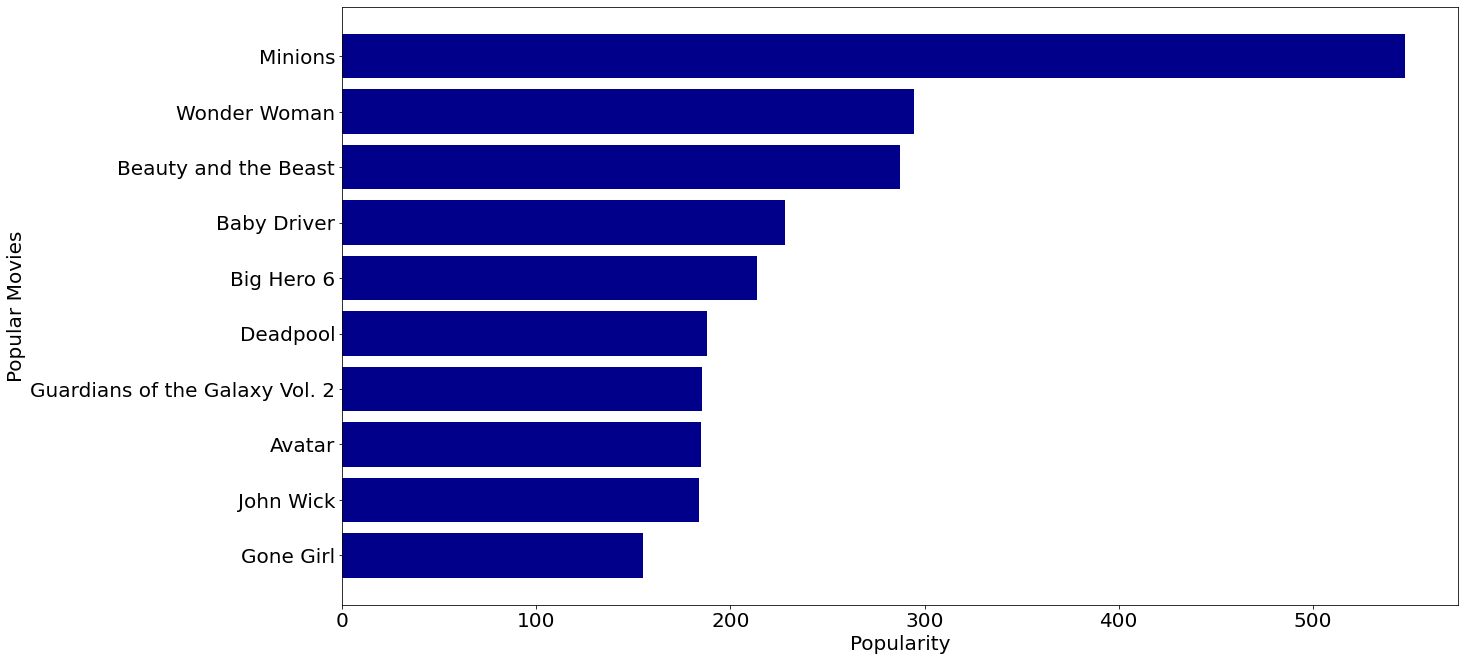

In [35]:
popular = q_movies.sort_values('popularity', ascending = False)
plt.figure(figsize = (20,11))

plt.rcParams['font.size'] = '20'
plt.barh(popular['title'].head(10), popular['popularity'].head(10),align = 'center', color='darkblue')
plt.gca().invert_yaxis()
plt.xlabel('Popularity',fontsize=20)
plt.ylabel('Popular Movies',fontsize=20)

Text(0.5, 1.0, 'High budget movies')

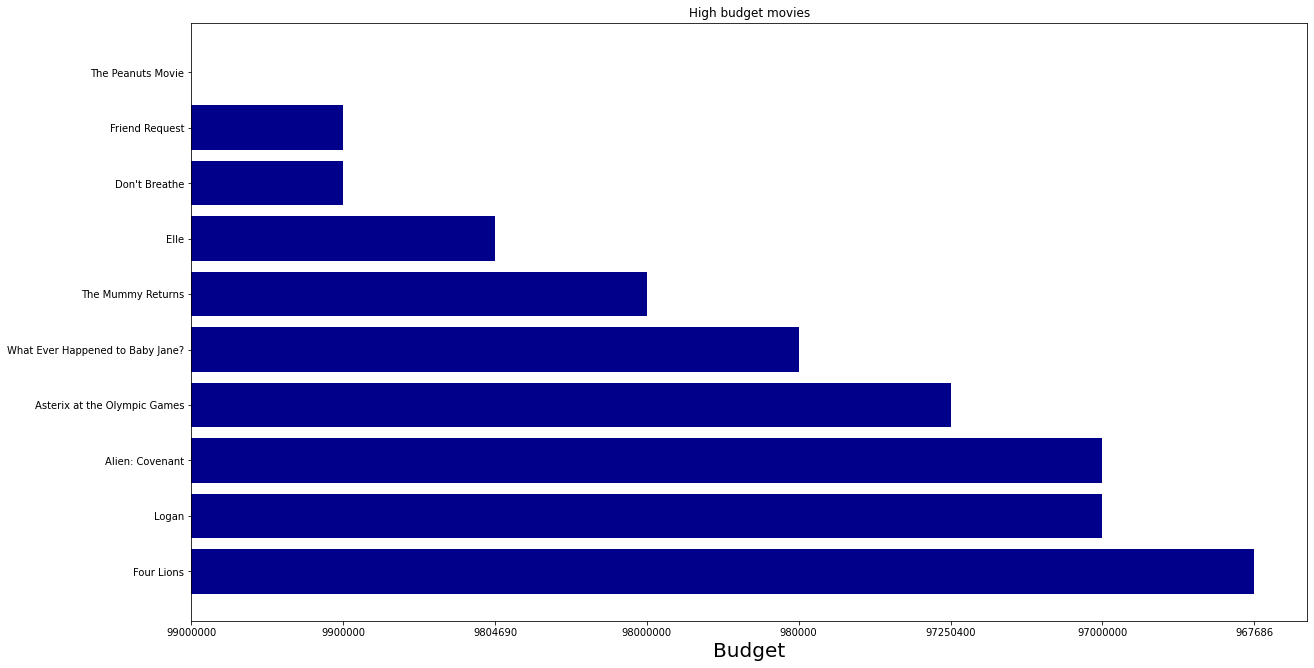

In [74]:
budget = q_movies.sort_values('budget', ascending = False)
plt.figure(figsize = (20,11))

plt.rcParams['font.size'] = '10'
plt.barh(budget['title'].head(10), budget['budget'].head(10),align = 'center', color='darkblue')

plt.gca().invert_yaxis()
plt.xlabel('Budget',fontsize=20)
plt.title("High budget movies")

Text(0.5, 1.0, 'High Revenue movies')

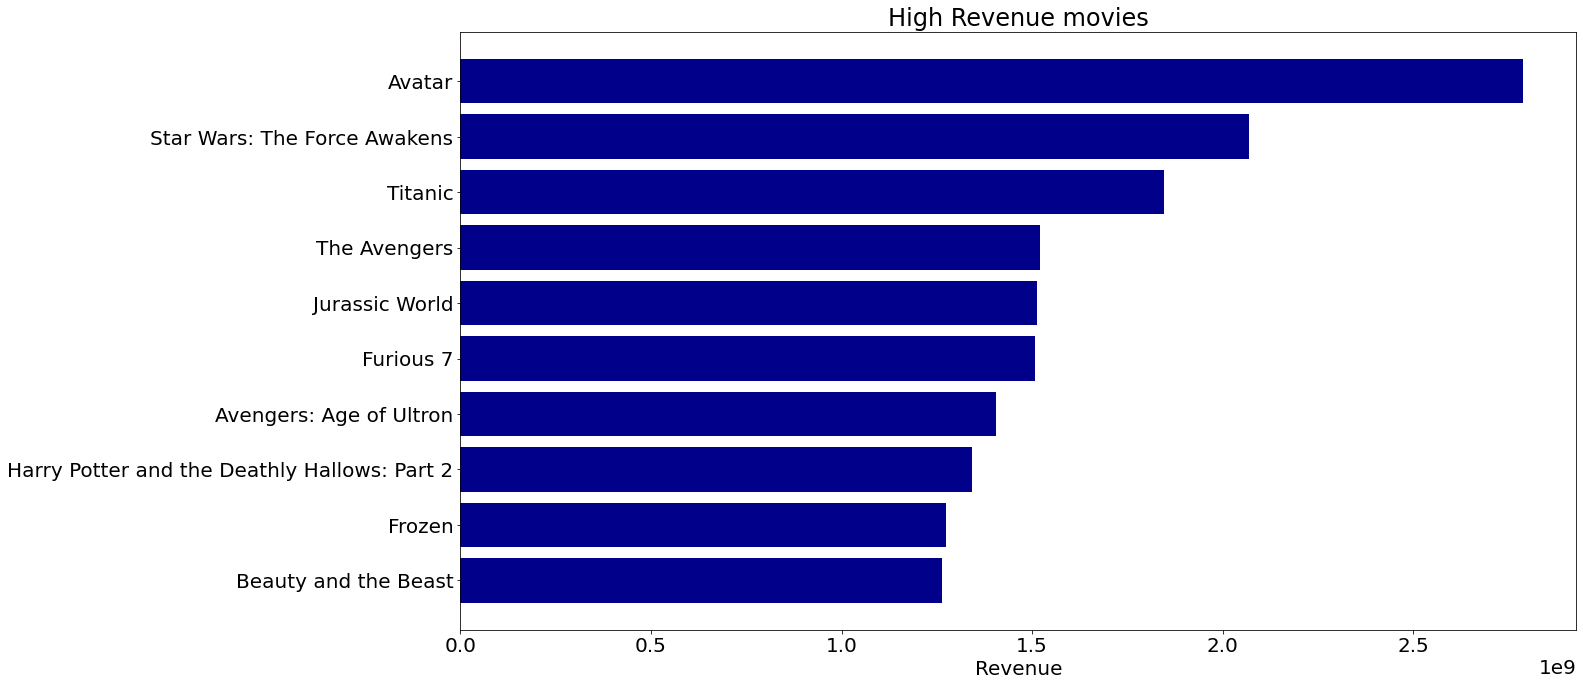

In [84]:
revenue = q_movies.sort_values('revenue', ascending = False)
plt.figure(figsize = (20,11))

plt.rcParams['font.size'] = '20'
plt.barh(revenue['title'].head(10), revenue['revenue'].head(10),align = 'center', color='darkblue')
plt.gca().invert_yaxis()
plt.xlabel('Revenue',fontsize=20)
plt.title("High Revenue movies")

In [81]:
 q_movies[['title','runtime']]

,title,runtime
314,The Shawshank Redemption,142.0
834,The Godfather,175.0
10309,Dilwale Dulhania Le Jayenge,190.0
12481,The Dark Knight,152.0
2843,Fight Club,139.0
...,...,...
9710,Son of the Mask,94.0
12911,Disaster Movie,87.0
3471,Battlefield Earth,118.0
11557,Epic Movie,86.0


In [99]:
db = runtime[['title','runtime']].where(runtime['runtime']>60)[0:50]

In [102]:
ndb = db.dropna()


Text(0.5, 1.0, 'Low runtime movies')

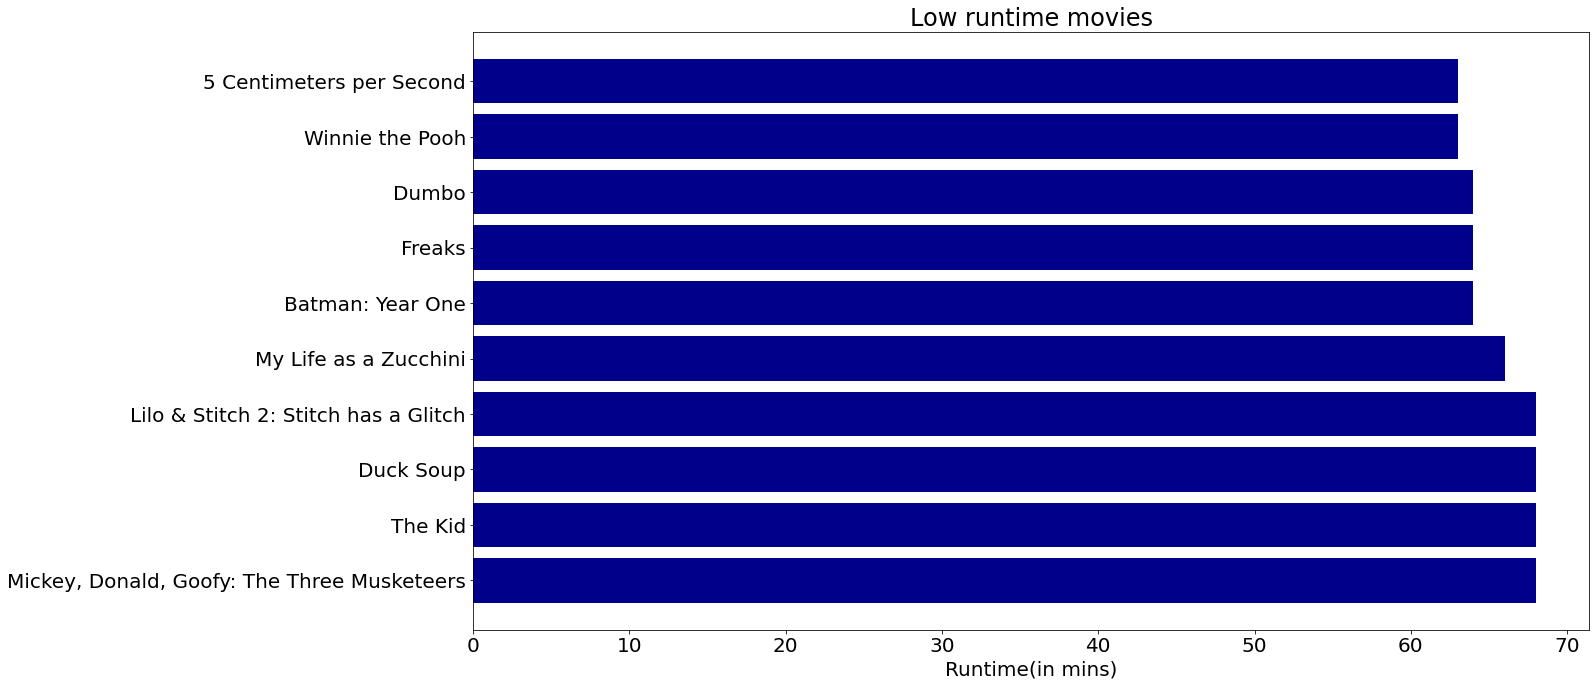

In [105]:
runtime = q_movies.sort_values('runtime', ascending = True)
plt.figure(figsize = (20,11))

plt.rcParams['font.size'] = '20'
plt.barh(ndb['title'].head(10), ndb['runtime'].head(10),align = 'center', color='darkblue')
plt.gca().invert_yaxis()
plt.xlabel('Runtime(in mins)',fontsize=20)
plt.title("Low runtime movies")

In [41]:
lang = q_movies['original_language'].value_counts()

In [59]:
lang.values

array([4077,  177,   65,   56,   38,   27,   19,   18,   14,   11,   11,
          8,    7,    6,    3,    3,    3,    2,    2,    1,    1,    1,
          1,    1,    1,    1,    1], dtype=int64)

In [60]:
lang.index

Index(['en', 'fr', 'ja', 'it', 'es', 'de', 'ko', 'cn', 'da', 'zh', 'sv', 'ru',
       'hi', 'pt', 'no', 'th', 'id', 'nl', 'sr', 'he', 'fa', 'hu', 'pl', 'el',
       'nb', 'tr', 'te'],
      dtype='object')

In [63]:
langs = ['English', 'French', 'Others']
nums = [4077,  177,   301]

In [62]:
arr = [65,   56,   38,   27,   19,   18,   14,   11,   11, 8,    7,    6,    3,    3,    3,    2,    2,    1,    1,    1, 1,    1,    1,    1,    1]
print(sum(arr))

301


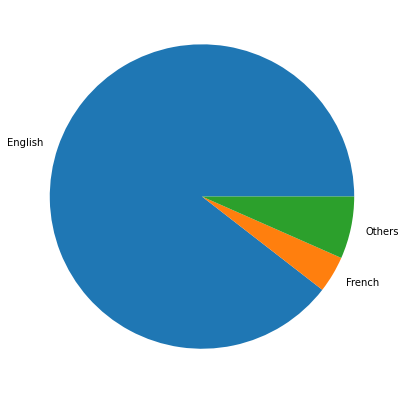

In [65]:
fig = plt.figure(figsize =(10, 7))
plt.pie(nums, labels = langs)
plt.rcParams['font.size'] = '10'
# show plot
plt.show()

In [44]:
q_movies.describe()


,revenue,runtime,vote_average,vote_count,score
count,4.555000e+03,4555.000000,4555.000000,4555.000000,4555.000000
mean,1.019829e+08,108.019319,6.473589,923.321405,6.272388
std,1.777554e+08,25.374595,0.837210,1291.009811,0.656166
min,0.000000e+00,0.000000,2.900000,160.000000,3.584903
25%,2.546031e+06,95.000000,5.900000,251.000000,5.815168
50%,3.917113e+07,105.000000,6.500000,433.000000,6.232772
75%,1.191987e+08,119.000000,7.100000,984.000000,6.693504
max,2.787965e+09,705.000000,9.100000,14075.000000,8.445869


In [109]:
q_movies = q_movies.sample(frac = 1)

In [110]:
q_movies_new = q_movies[['title', 'vote_count', 'vote_average', 'score']]

In [111]:
q_movies_new.head()

,title,vote_count,vote_average,score
31751,Dark Places,488.0,5.7,5.679804
878,It Happened One Night,283.0,7.7,6.948111
39201,Like Crazy,187.0,7.3,6.524534
6714,School of Rock,1454.0,6.8,6.682846
3131,The Hand that Rocks the Cradle,196.0,6.5,6.103689


In [324]:
tmae = []
trmse = []
tmse = []
totalaccuracy = []

In [120]:
from sklearn.metrics import plot_confusion_matrix ,confusion_matrix, precision_score, recall_score, f1_score


Linear Regression

In [302]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [303]:
X_new = q_movies_new[['vote_count', 'vote_average']]
Y_new = q_movies_new[['score']]
model = LinearRegression()

In [304]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3051, 2) (1504, 2) (3051, 1) (1504, 1)


In [325]:
model.fit(X_train,y_train)

LinearRegression()

In [326]:

acc = model.score(X_test, y_test)
model.score(X_test, y_test)

0.9594391998478893

In [327]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
Y_pred = model.predict(X_test)


MSE = mean_squared_error(y_test, Y_pred)
RMSE = mean_squared_error(y_test, Y_pred, squared=False)
MAE = mean_absolute_error(y_test, Y_pred)
print(round(MSE*100,2))
print(round(RMSE*100,2))
print(round(MAE*100,2))

1.82
13.51
9.64


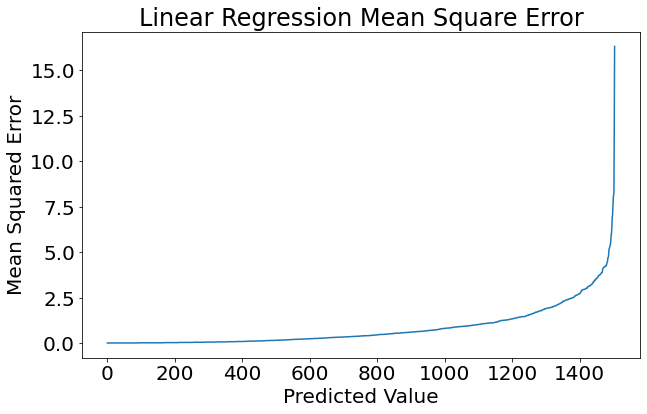

In [308]:
errors = list()
for i in range(len(y_test_list)):
    err = round(float((y_test_list[i] - Y_pred[i])**2),2)
    errors.append(err)

a = errors
a.sort()


plt.figure(figsize = (10,6))
plt.plot(a)

plt.xlabel('Predicted Value')
plt.ylabel('Mean Squared Error')
plt.title("Linear Regression Mean Square Error")
plt.show()

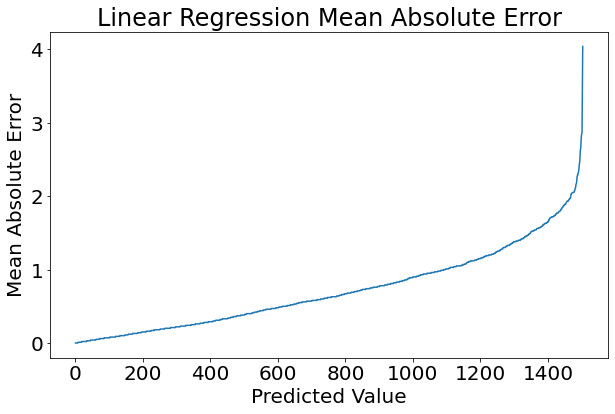

In [309]:
errors = list()
for i in range(len(y_test_list)):
    err = round(float(abs((y_test_list[i] - Y_pred[i]))),2)
    errors.append(err)

a = errors
a.sort()


plt.figure(figsize = (10,6))
plt.plot(a)

plt.xlabel('Predicted Value')
plt.ylabel('Mean Absolute Error')
plt.title("Linear Regression Mean Absolute Error")
plt.show()

In [328]:
tmse.append(round(MSE*100,2))
trmse.append(round(RMSE*100,2))
tmae.append(round(MAE*100,2))
totalaccuracy.append(round(acc*100,2))

Decision Tree

In [311]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(max_depth=3)
regr.fit(X_train, y_train)
scoreacc = regr.score(X_test,y_test)
print(scoreacc)

0.9163124554573264


In [329]:
Y_pred = regr.predict(X_test)


MSE = mean_squared_error(y_test, Y_pred)
RMSE = mean_squared_error(y_test, Y_pred, squared=False)
MAE = mean_absolute_error(y_test, Y_pred)

print(round(MSE*100,2))
print(round(RMSE*100,2))
print(round(MAE*100,2))
print(scoreacc)

tmse.append(round(MSE*100,2))
trmse.append(round(RMSE*100,2))
tmae.append(round(MAE*100,2))
totalaccuracy.append(round(scoreacc*100,2))

3.77
19.4
14.56
0.9163124554573264


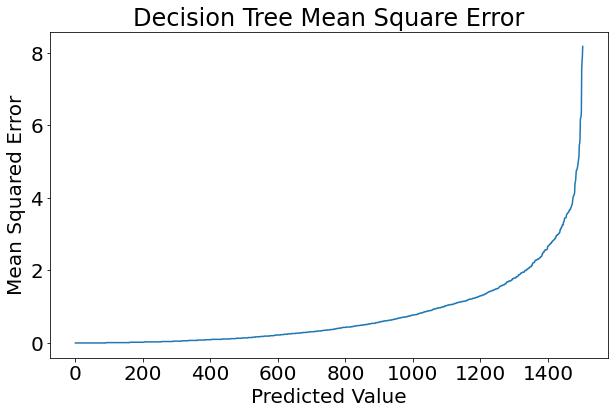

In [313]:
errors = list()
for i in range(len(y_test_list)):
    err = round(float((y_test_list[i] - Y_pred[i])**2),2)
    errors.append(err)

a = errors
a.sort()


plt.figure(figsize = (10,6))
plt.plot(a)

plt.xlabel('Predicted Value')
plt.ylabel('Mean Squared Error')
plt.title("Decision Tree Mean Square Error")
plt.show()

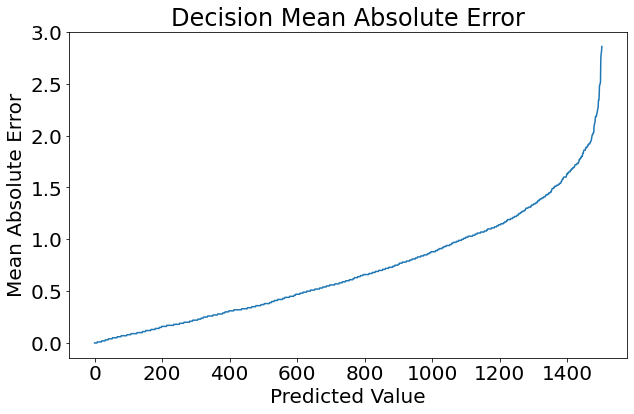

In [314]:
errors = list()
for i in range(len(y_test_list)):
    err = round(float(abs((y_test_list[i] - Y_pred[i]))),2)
    errors.append(err)

a = errors
a.sort()


plt.figure(figsize = (10,6))
plt.plot(a)

plt.xlabel('Predicted Value')
plt.ylabel('Mean Absolute Error')
plt.title("Decision Mean Absolute Error")
plt.show()

In [54]:
from sklearn import tree
tree.export_text(regr)

'|--- feature_1 <= 6.45\n|   |--- feature_1 <= 5.65\n|   |   |--- feature_1 <= 4.95\n|   |   |   |--- value: [4.92]\n|   |   |--- feature_1 >  4.95\n|   |   |   |--- value: [5.45]\n|   |--- feature_1 >  5.65\n|   |   |--- feature_1 <= 6.05\n|   |   |   |--- value: [5.80]\n|   |   |--- feature_1 >  6.05\n|   |   |   |--- value: [6.08]\n|--- feature_1 >  6.45\n|   |--- feature_1 <= 7.25\n|   |   |--- feature_0 <= 531.50\n|   |   |   |--- value: [6.38]\n|   |   |--- feature_0 >  531.50\n|   |   |   |--- value: [6.69]\n|   |--- feature_1 >  7.25\n|   |   |--- feature_0 <= 662.50\n|   |   |   |--- value: [6.88]\n|   |   |--- feature_0 >  662.50\n|   |   |   |--- value: [7.47]\n'

In [55]:
feature_names = ['vote_count', 'vote_average']

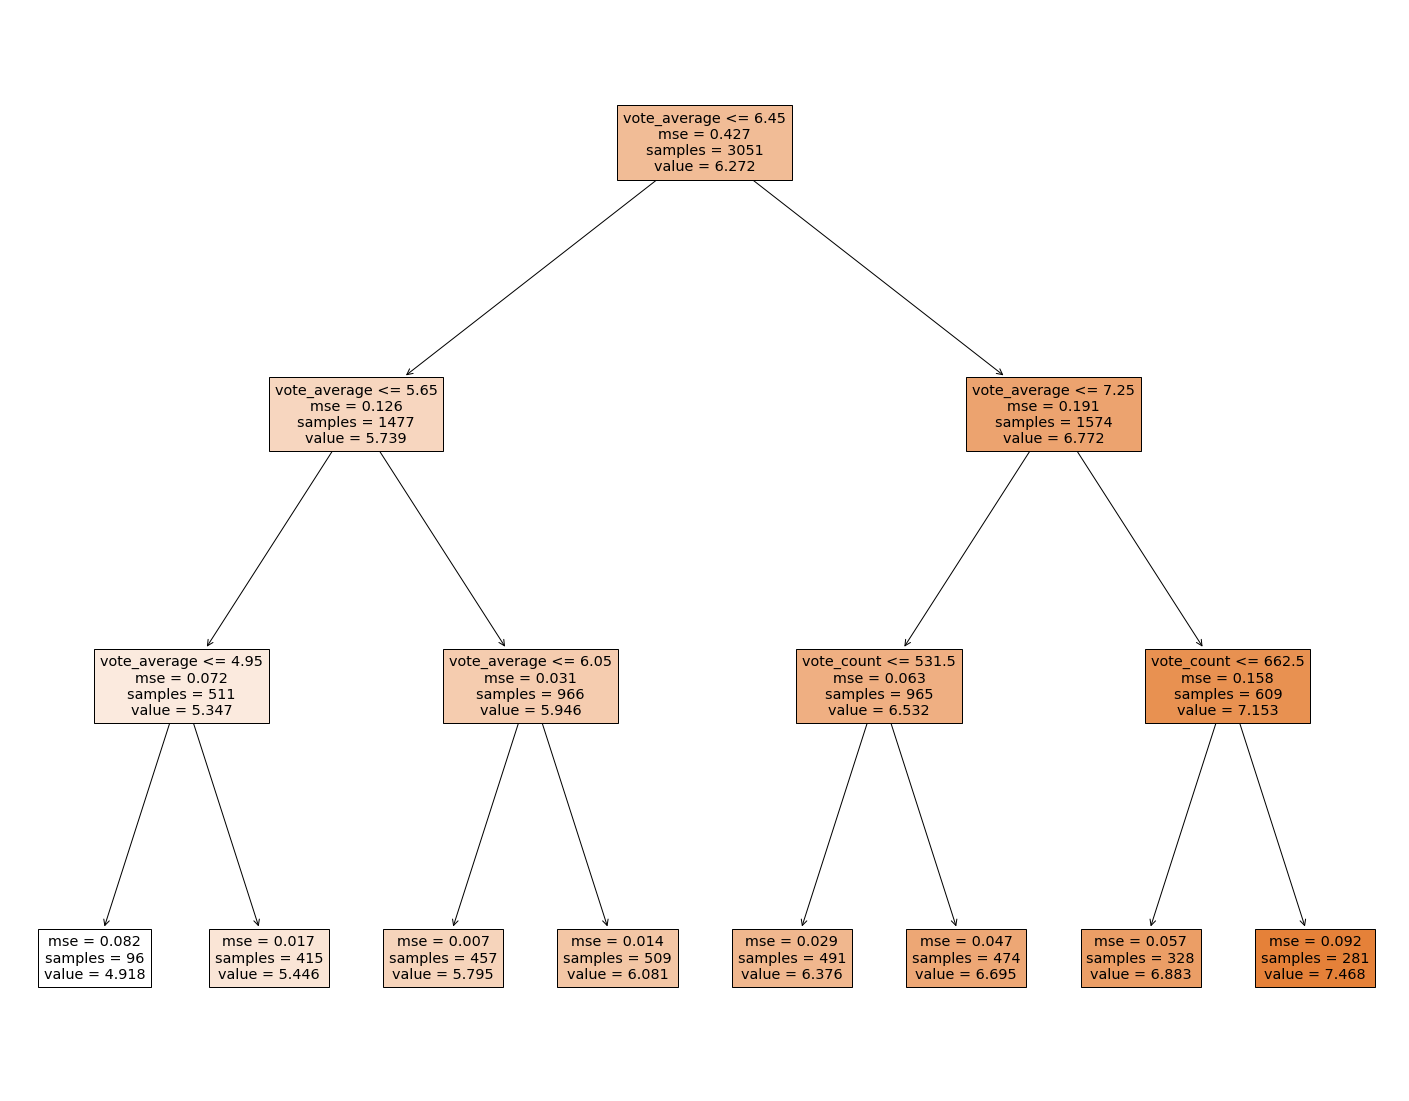

In [56]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(regr, feature_names=feature_names, filled=True)

Lasso Regression

In [315]:
from sklearn import linear_model

lassoReg = linear_model.Lasso(alpha=0.1)
lassoReg.fit(X_train,y_train)
scorelasso = lassoReg.score(X_test,y_test)
print(scorelasso)

0.9221551236403953


In [330]:
Y_pred = lassoReg.predict(X_test)


MSE = mean_squared_error(y_test, Y_pred)
RMSE = mean_squared_error(y_test, Y_pred, squared=False)
MAE = mean_absolute_error(y_test, Y_pred)

print(round(MSE*100,2))
print(round(RMSE*100,2))
print(round(MAE*100,2))
print(scorelasso)

tmse.append(round(MSE*100,2))
trmse.append(round(RMSE*100,2))
tmae.append(round(MAE*100,2))
totalaccuracy.append(round(scorelasso*100,2))

3.5
18.71
13.98
0.9221551236403953


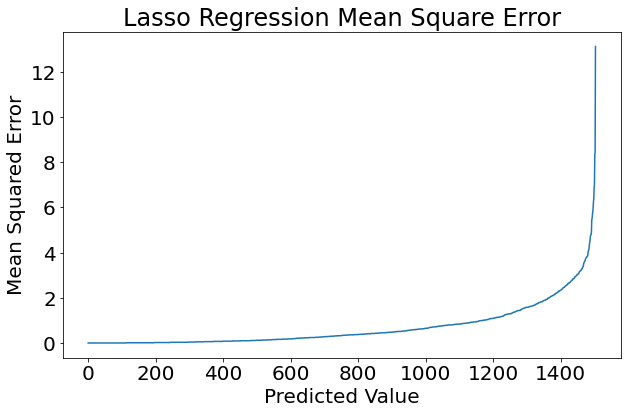

In [317]:
errors = list()
for i in range(len(y_test_list)):
    err = round(float((y_test_list[i] - Y_pred[i])**2),2)
    errors.append(err)

a = errors
a.sort()


plt.figure(figsize = (10,6))
plt.plot(a)

plt.xlabel('Predicted Value')
plt.ylabel('Mean Squared Error')
plt.title("Lasso Regression Mean Square Error")
plt.show()

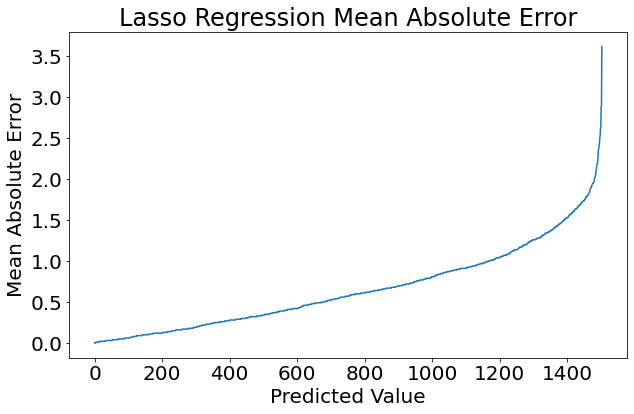

In [318]:
errors = list()
for i in range(len(y_test_list)):
    err = round(float(abs((y_test_list[i] - Y_pred[i]))),2)
    errors.append(err)

a = errors
a.sort()


plt.figure(figsize = (10,6))
plt.plot(a)

plt.xlabel('Predicted Value')
plt.ylabel('Mean Absolute Error')
plt.title("Lasso Regression Mean Absolute Error")
plt.show()


Random Forest


In [319]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
X, y = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
rfr = RandomForestRegressor(max_depth=3)
rfr.fit(X_train, y_train)
accrf = rfr.score(X_test,y_test)
print(rfr.score(X_test,y_test))

0.9399519596802174


C:\Users\Dell\AppData\Local\Temp/ipykernel_24540/673774919.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


In [331]:
Y_pred = rfr.predict(X_test)


MSE = mean_squared_error(y_test, Y_pred)
RMSE = mean_squared_error(y_test, Y_pred, squared=False)
MAE = mean_absolute_error(y_test, Y_pred)

print(round(MSE*100,2))
print(round(RMSE*100,2))
print(round(MAE*100,2))
print(accrf)

tmse.append(round(MSE*100,2))
trmse.append(round(RMSE*100,2))
tmae.append(round(MAE*100,2))
totalaccuracy.append(round(accrf*100,2))

2.7
16.44
11.62
0.9399519596802174


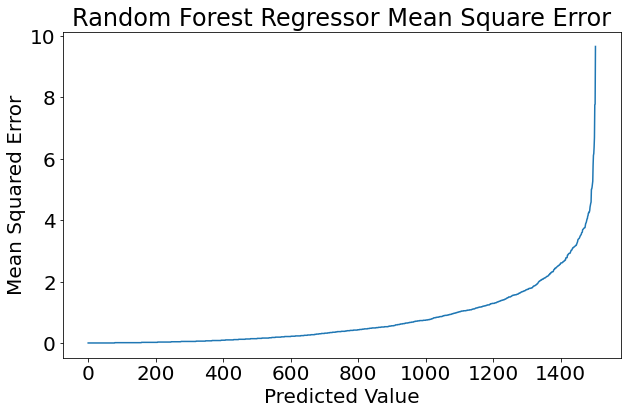

In [321]:
errors = list()
for i in range(len(y_test_list)):
    err = round(float((y_test_list[i] - Y_pred[i])**2),2)
    errors.append(err)

a = errors
a.sort()


plt.figure(figsize = (10,6))
plt.plot(a)

plt.xlabel('Predicted Value')
plt.ylabel('Mean Squared Error')
plt.title("Random Forest Regressor Mean Square Error")
plt.show()

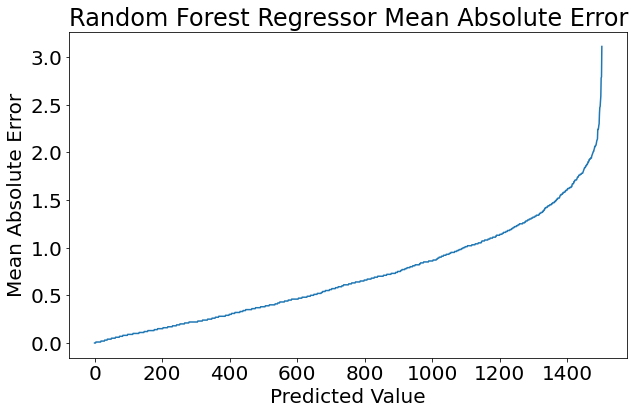

In [322]:
errors = list()
for i in range(len(y_test_list)):
    err = round(float(abs((y_test_list[i] - Y_pred[i]))),2)
    errors.append(err)

a = errors
a.sort()


plt.figure(figsize = (10,6))
plt.plot(a)

plt.xlabel('Predicted Value')
plt.ylabel('Mean Absolute Error')
plt.title("Random Forest Regressor Mean Absolute Error")
plt.show()

In [332]:
print(tmse,trmse,tmae,totalaccuracy)

[1.82, 3.77, 3.5, 2.7] [13.51, 19.4, 18.71, 16.44] [9.64, 14.56, 13.98, 11.62] [95.94, 91.63, 92.22, 94.0]


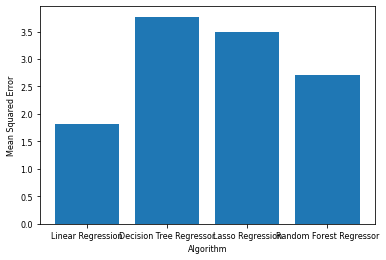

In [336]:
x_label_g = ['Linear Regression','Decision Tree Regressor','Lasso Regression', 'Random Forest Regressor']
plt.rcParams['font.size'] = '8'
plt.bar(x_label_g,tmse)
plt.xlabel("Algorithm")
plt.ylabel("Mean Squared Error")

plt.show()

[Text(697.5, 951.3000000000001, 'vote_average <= 6.45\nmse = 0.427\nsamples = 1930\nvalue = 6.283'),
 Text(348.75, 679.5, 'vote_average <= 5.65\nmse = 0.127\nsamples = 917\nvalue = 5.741'),
 Text(174.375, 407.70000000000005, 'vote_average <= 4.95\nmse = 0.07\nsamples = 317\nvalue = 5.347'),
 Text(87.1875, 135.89999999999998, 'mse = 0.091\nsamples = 62\nvalue = 4.926'),
 Text(261.5625, 135.89999999999998, 'mse = 0.015\nsamples = 255\nvalue = 5.444'),
 Text(523.125, 407.70000000000005, 'vote_average <= 6.05\nmse = 0.029\nsamples = 600\nvalue = 5.953'),
 Text(435.9375, 135.89999999999998, 'mse = 0.008\nsamples = 278\nvalue = 5.804'),
 Text(610.3125, 135.89999999999998, 'mse = 0.013\nsamples = 322\nvalue = 6.076'),
 Text(1046.25, 679.5, 'vote_average <= 7.25\nmse = 0.193\nsamples = 1013\nvalue = 6.772'),
 Text(871.875, 407.70000000000005, 'vote_count <= 406.5\nmse = 0.06\nsamples = 630\nvalue = 6.526'),
 Text(784.6875, 135.89999999999998, 'mse = 0.025\nsamples = 281\nvalue = 6.356'),
 Text

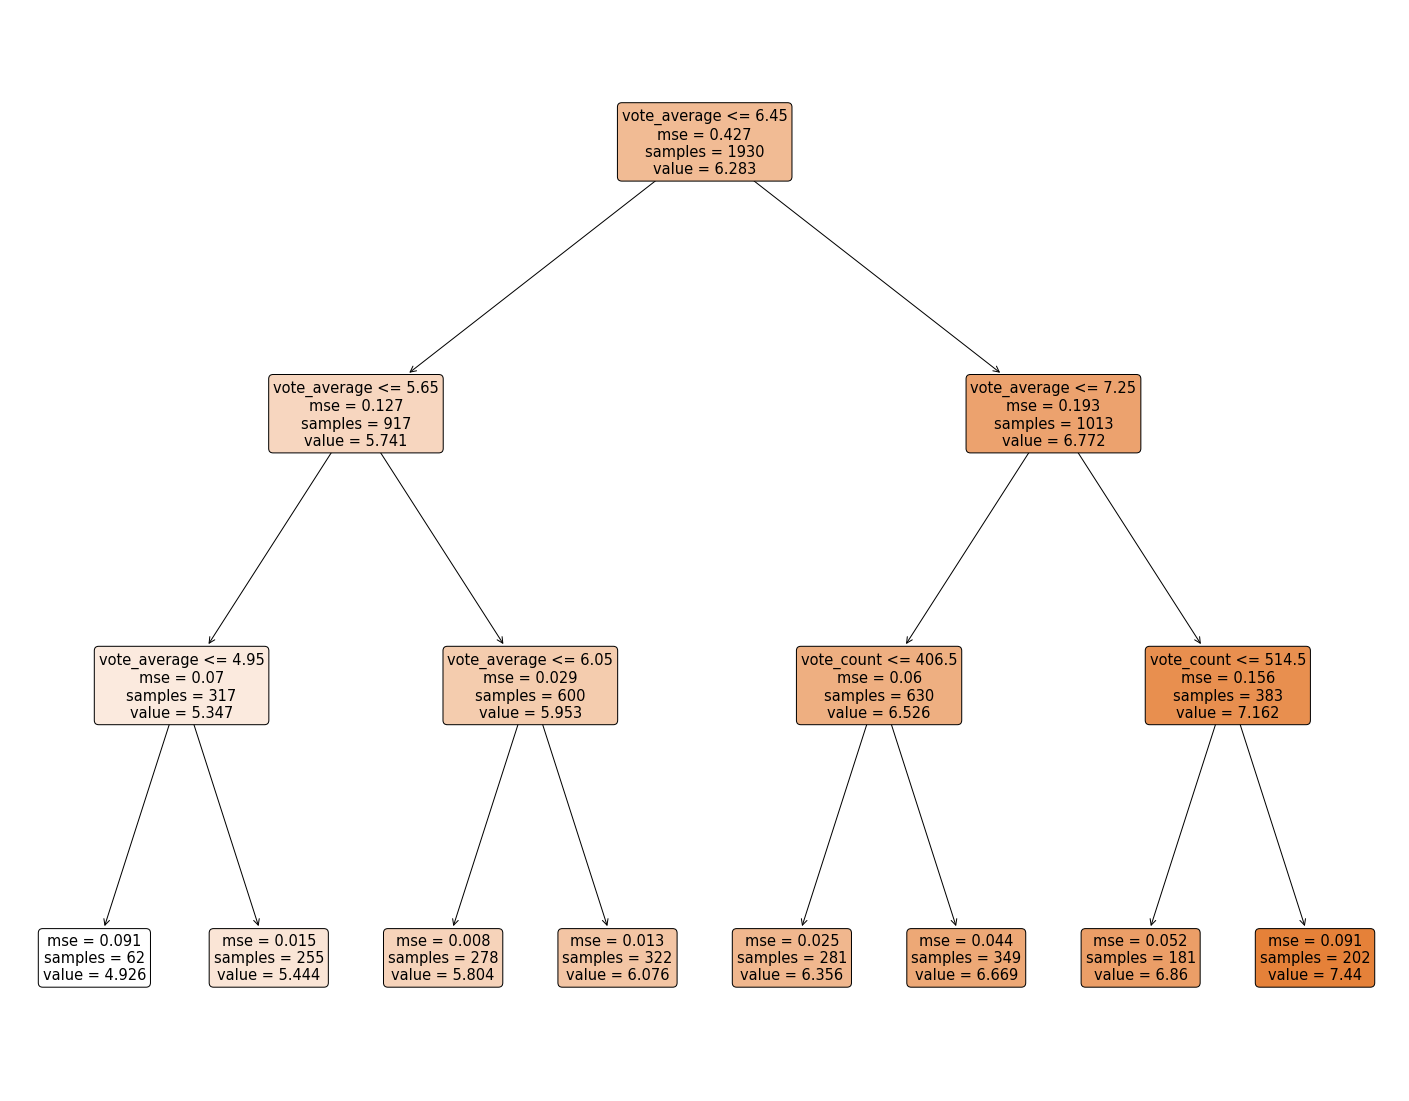

In [59]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(rfr.estimators_[0], 
          feature_names=feature_names, 
          filled=True, impurity=True, 
          rounded=True)

In [60]:
q_movies.shape

(4555, 25)

In [61]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
q_movies['overview'] = q_movies['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(q_movies['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4555, 19694)

In [62]:
tfidf_matrix

<4555x19694 sparse matrix of type '<class 'numpy.float64'>'
	with 115437 stored elements in Compressed Sparse Row format>

In [63]:
tfidf.get_feature_names()[5000:5010]

['did',
 'didn',
 'dido',
 'die',
 'died',
 'diego',
 'dies',
 'diesel',
 'diet',
 'dietary']

In [64]:
# Import linear_kernel

from sklearn.metrics.pairwise import linear_kernel
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [65]:
cosine_sim.shape

(4555, 4555)

In [66]:
cosine_sim[1]

array([0., 1., 0., ..., 0., 0., 0.])

In [67]:
indices = pd.Series(q_movies.index, index=q_movies['title']).drop_duplicates()

In [68]:
q_movies.index

Int64Index([ 1585, 16054, 36248,  1168,  3192,  1196, 16737,  8189, 10335,
             1208,
            ...
            16121,  3618, 23108,  2319,  5695, 15581,  7827,   876,  4748,
             5806],
           dtype='int64', length=4555)

In [69]:
q_movies['title']

1585                         Stripes
16054                       Due Date
36248                           Race
1168                 Wings of Desire
3192                         The Kid
                    ...             
15581                 The Other Guys
7827     Around the World in 80 Days
876                          Vertigo
4748                    Donnie Darko
5806              Star Trek: Nemesis
Name: title, Length: 4555, dtype: object

In [77]:
q_movies.index[300]

36446

In [70]:
indices[:10]

title
Stripes                           1585
Due Date                         16054
Race                             36248
Wings of Desire                   1168
The Kid                           3192
Braindead                         1196
Drive Angry                      16737
Shall We Dance?                   8189
Proof                            10335
The Day the Earth Stood Still     1208
dtype: int64

In [71]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return metadata['title'].iloc[movie_indices]

In [83]:
get_recommendations('Forrest Gump')

4029                   Sweet November
782               Walking and Talking
797               Death in the Garden
1474    The Lost World: Jurassic Park
370                      Safe Passage
913      The Adventures of Robin Hood
3                   Waiting to Exhale
2624                 The Color Purple
4171                  A Knight's Tale
4461            Enemies: A Love Story
Name: title, dtype: object

In [60]:
a = [5,3,2,4]
b = [3,4,2,5]
c = [1,5,3,2]
d = [2,3,5,4]

In [79]:
title2 = ['a', 'b', 'c', 'd']

In [81]:
f = pd.DataFrame(list(zip(title2, a, b, c, d)),
               columns =['title','x1', 'x2', 'x3', 'x4'])

In [82]:
f

,title,x1,x2,x3,x4
0,a,5,3,1,2
1,b,3,4,5,3
2,c,2,2,3,5
3,d,4,5,2,4


In [87]:
f_new = f.drop(['title'],axis = 1)

In [88]:
f_new

,x1,x2,x3,x4
0,5,3,1,2
1,3,4,5,3
2,2,2,3,5
3,4,5,2,4


In [89]:
cosine_sim2 = linear_kernel(f_new, f_new)

In [90]:
cosine_sim2[1]

array([38., 59., 44., 54.])

In [91]:
indices2 = pd.Series(f.index, index=f['title']).drop_duplicates()

In [92]:
indices2

title
a    0
b    1
c    2
d    3
dtype: int64

In [96]:
def get_recommendations2(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices2[title]
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return f['title'].iloc[movie_indices]

In [97]:
get_recommendations2('a')

0    a
1    b
2    c
Name: title, dtype: object

In [150]:
from sklearn.metrics import roc_curve

In [ ]:
for i in range(len(expected)):
	
	err = (X_test[i] - y_pred[i])**2
	
	errors.append(err)
	# report error
	print('>%.1f, %.1f = %.3f' % (X_test[i], X_test[i], err))
plt.plot(errors)
plt.xticks(ticks=[i for i in range(len(errors))], labels=predicted)
plt.xlabel('Predicted Value')
plt.ylabel('Mean Squared Error')
plt.xtitle("Lasso Regression Mean Square Error")
plt.show()